In [3]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import numpy as np
from numpy import linspace, meshgrid
from mpl_toolkits import mplot3d
from scipy.stats import norm
from scipy.optimize import root_scalar

In [62]:
def plot_charts(R,V,z,y,fees, MM_PnL):
    fig,axs = plt.subplots(3,2, sharex=True)
    fig.set_size_inches(15,15)
    # Rate curves
    axs[0,0].plot(R, label = 'rates')
    axs[0,0].set_title('Interest rate')
    # Pool value
    axs[0,1].plot(V, label = 'pool value')
    axs[0,1].set_title('Pool value')
    # Bond reserves
    axs[1,0].plot(z, label = 'bond reserves')
    axs[1,0].set_title('Bond reserves')
    # Cash reserves
    axs[1,1].plot(y, label = 'cash')
    axs[1,1].set_title('Cash reserves')
    # total fees
    axs[2,0].plot(fees, label = 'Fees')
    axs[2,0].set_title('Trading fees')
    # MM PnL
    axs[2,1].plot(MM_PnL, label = 'MM PnL')
    axs[2,1].set_title('MM PnL')
    # plots   
    for ax in fig.axes:
        #ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
        ax.grid(True)
        ax.legend(loc='upper right')
    plt.savefig("Bond_AMM.png")
    plt.show()
    return

In [4]:
def random_simulation(init_value, limit_value, reversion_rate, annualized_vol,num_year, num_sim, trade_freq, method):
    num_step=int(trade_freq*60*24*365*num_year)
    time_step=num_year/num_step
    nrv = norm.rvs(size=(num_sim,num_step), scale=annualized_vol*math.sqrt(time_step))
    out=np.zeros((num_sim,num_step+1))
    out[:,0]=init_value
    if method=='wiener':
        out=np.cumprod(np.concatenate([[init_value],1+nrv]))
    if method=='vacicek':
        for i in range(num_step):
            out[:,i+1]=out[:,i]+reversion_rate*(limit_value-out[:,i])+nrv[:,i]
    if method=='cir':
        for i in range(num_step):
            out[:,i+1]=out[:,i]+reversion_rate*(limit_value-out[:,i])+np.sqrt(out[:,i])*nrv[:,i]
    return out

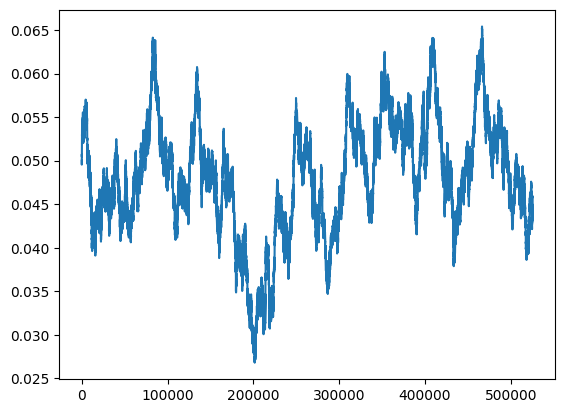

In [5]:
init_value=0.050
limit_value=0.050
reversion_rate=0.00005
annualized_vol=0.050
num_year=1
num_sim=1
trade_freq=1
method='vacicek'
R=random_simulation(init_value, limit_value, reversion_rate, annualized_vol,num_year, num_sim, trade_freq, method)[0]
plt.plot(R)



In [6]:
print('Rate std: ', round(np.std(R),3))
r_band=round(np.std(R)*5,2)
r_min=init_value-r_band
r_max=init_value+r_band
print (r_min, r_max)


Rate std:  0.007
0.020000000000000004 0.08


In [16]:
def rate_to_tx(R, r_min, r_max, x0,y0,maturity, trade_freq): # between two consecutive trades
    if abs(R[0]-r_min-(r_max-r_min)*x0/(x0+y0*np.exp(maturity*R[0])))>1e-12:
        raise Exception('The fixed point equation is not satisfied at the beginning!')
    dt=1/(trade_freq*60*24*365)
    tau=maturity-dt*np.arange(len(R))
    A=y0/((r_max - R[0]) * np.exp(-(r_max - R[0])**2 / (2 * (r_max - r_min)) * maturity - R[0] * maturity))
    x=A * (R - r_min) * np.exp(-(r_max - R)* (r_max - R) / (2 * (r_max - r_min)) * tau)
    y=A * (r_max - R) * np.exp(-(r_max - R)* (r_max - R) / (2 * (r_max - r_min)) * tau - R * tau)
    return [x,y]

In [28]:
def rate_to_tx(R, r_min, r_max, z0,y0,maturity, trade_freq): # one maturity
    if abs(R[0]-r_min-(r_max-r_min)*z0/(z0+y0))>1e-12:
        raise Exception('The fixed point equation is not satisfied at the beginning!')
    dt=1/(trade_freq*60*24*365)
    tau=maturity-dt*np.arange(len(R))
    Dx=np.zeros(len(R))
    y=np.zeros(len(R))
    z=np.zeros(len(R))
    Dx[0]=0
    y[0]=y0
    z[0]=z0#z0=x0*np.exp(-maturity*R[0])
    A=y0/((r_max - R[0]) * np.exp(-(r_max - R[0])**2 / (2 * (r_max - r_min)) * maturity - R[0] * maturity))
    for i in range(len(R)-1):
        A*=np.exp(-(r_max - R[i])*(r_max - R[i])/ (2 * (r_max - r_min)) * dt - R[i] * dt) # to ensure y is fixed
        x_pre_trade=A * (R[i] - r_min) * np.exp(-(r_max - R[i])* (r_max - R[i]) / (2 * (r_max - r_min)) * tau[i+1])
        x_post_trade=A * (R[i+1] - r_min) * np.exp(-(r_max - R[i+1])* (r_max - R[i+1]) / (2 * (r_max - r_min)) * tau[i+1])
        Dx[i+1]=x_post_trade-x_pre_trade
        y[i+1]=A * (r_max - R[i+1]) * np.exp(-(r_max - R[i+1])* (r_max - R[i+1]) / (2 * (r_max - r_min)) * tau[i+1] - R[i+1] * tau[i+1])
        z[i+1]=y[i+1]*(R[i+1]-r_min)/(r_max-R[i+1]) #z[i+1]=x_post_trade*np.exp(-R[i+1]*tau[i+1])
    return [z,y,Dx]


In [23]:
def rate_to_tx(R, r_min, r_max, z0,y0,maturities, trade_freq): # multiple maturities
    if abs(R[0]-r_min-(r_max-r_min)*z0/(z0+y0))>1e-12:
        raise Exception('The fixed point equation is not satisfied at the beginning!')
    dt=1/(trade_freq*60*24*365)
    tau=maturities-dt*np.arange(len(R)) # maturities is a vector
    Dx=np.zeros(len(R))
    y=np.zeros(len(R))
    z=np.zeros(len(R))
    Dx[0]=0
    y[0]=y0
    z[0]=z0
    for i in range(len(R)-1): # right before the trade at i+1
        A=y[i]/((r_max - R[i]) * np.exp(-(r_max - R[i])*(r_max - R[i]) / (2 * (r_max - r_min)) * tau[i+1] - R[i] * tau[i+1]))
        y[i+1]=A * (r_max - R[i+1]) * np.exp(-(r_max - R[i+1])* (r_max - R[i+1]) / (2 * (r_max - r_min)) * tau[i+1] - R[i+1] * tau[i+1])
        z[i+1]=y[i+1]*(R[i+1]-r_min)/(r_max-R[i+1])
        x_pre_trade=A * (R[i] - r_min) * np.exp(-(r_max - R[i])* (r_max - R[i]) / (2 * (r_max - r_min)) * tau[i+1])
        x_post_trade=A * (R[i+1] - r_min) * np.exp(-(r_max - R[i+1])* (r_max - R[i+1]) / (2 * (r_max - r_min)) * tau[i+1])
        Dx[i+1]=x_post_trade-x_pre_trade
    return [z,y,Dx]

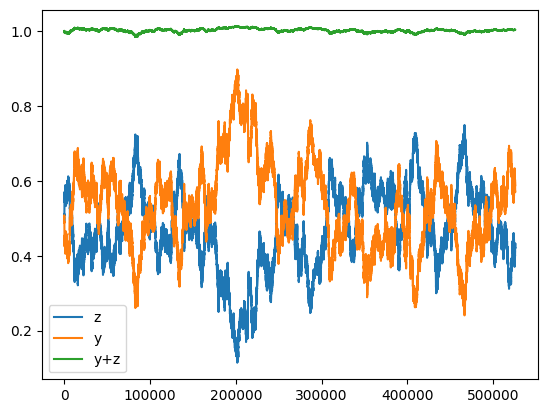

In [63]:
y0=0.5
z0=0.5
maturity=2
[z,y,Dx]=rate_to_tx(R, r_min, r_max, z0,y0,maturity, trade_freq)
plt.plot(z, label='z')
plt.plot(y, label='y')
plt.plot(y+z, label='y+z')
plt.legend()
plt.show()

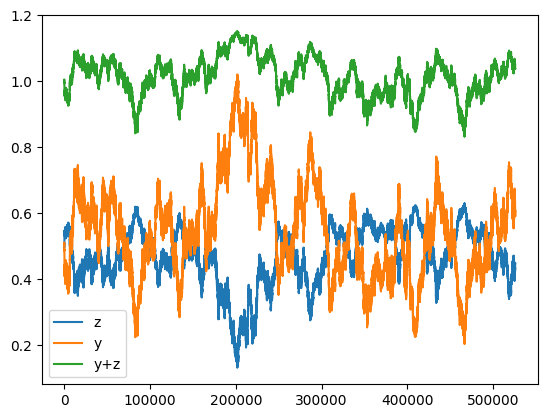

In [42]:
y0=0.5
z0=0.5
maturity=20

[z,y,Dx]=rate_to_tx(R, r_min, r_max, z0,y0,maturity, trade_freq)
plt.plot(z, label='z')
plt.plot(y, label='y')
plt.plot(y+z, label='y+z')
plt.legend()
plt.show()


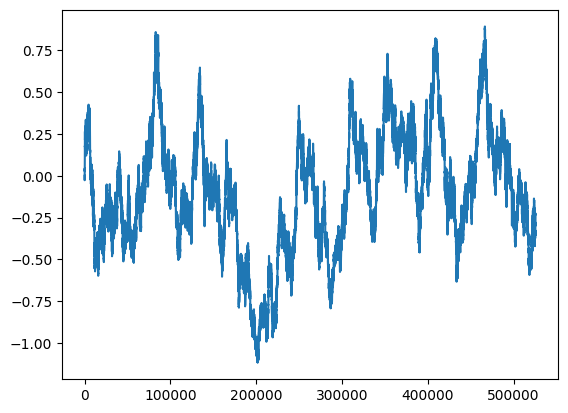

In [44]:
plt.plot(np.cumsum(Dx)) # net bond position, positive means there are more lenders than borrowers


In [59]:

def backtest(R,rate_to_tx,r_min,r_max,z0,y0,maturity,trade_freq, fee=0.0001): 
    N=len(R)
    dt=1/(trade_freq*60*24*365)
    tau=maturity-dt*np.arange(len(R))
    [z,y,Dx]=rate_to_tx(R, r_min, r_max, z0,y0,maturity, trade_freq)
    V=z+y
    fees=(fee*tau*np.abs(np.concatenate([[0],np.diff(y)]))).cumsum()
    MM_PnL=V-V[0]+fees
    statistic_table=round(100*pd.Series(index=['IL', 'Fees','MM PnL'],data=[V[-1]-1, fees[-1],MM_PnL[-1]]),2)
    print(statistic_table)
    return  [R,V,z,y,fees, MM_PnL]

In [64]:
# in percentage
# maturity=2 years
[R,z,y,V,fees, MM_PnL]=backtest(R,rate_to_tx,r_min,r_max,z0,y0,maturity,trade_freq, fee=0.0001)

IL        0.25
Fees      7.39
MM PnL    7.64
dtype: float64


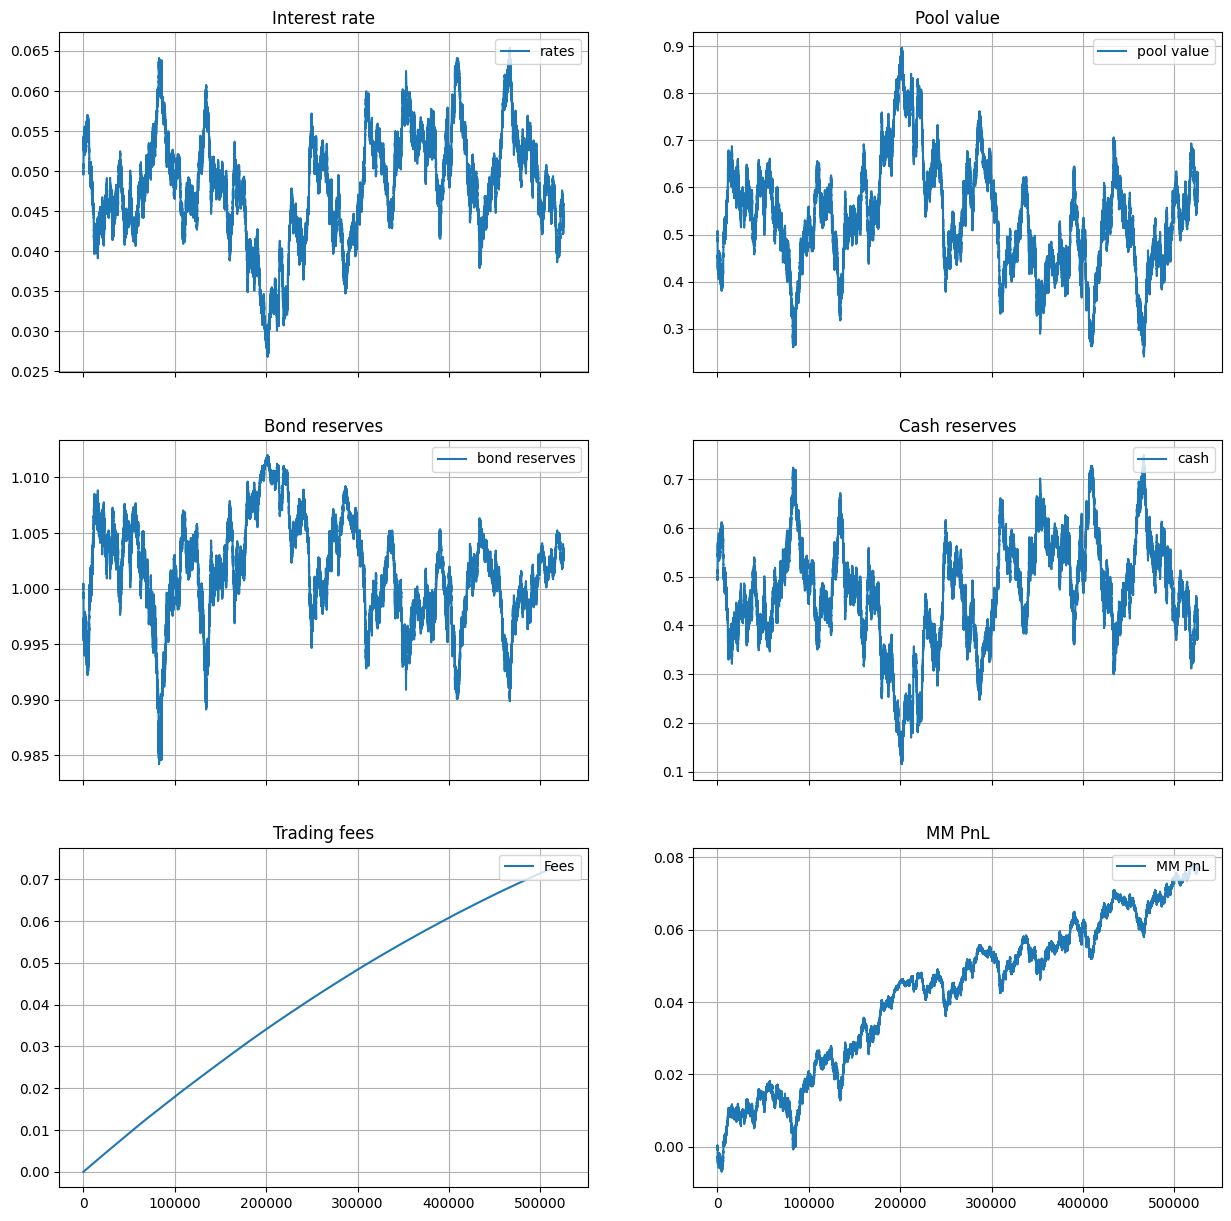

In [65]:
plot_charts(R,V,z,y,fees, MM_PnL)

In [60]:
# in percentage
# maturity=20 years
[R,z,y,V,fees, MM_PnL]=backtest(R,rate_to_tx,r_min,r_max,z0,y0,maturity,trade_freq, fee=0.0001)

IL          3.83
Fees      121.46
MM PnL    125.29
dtype: float64


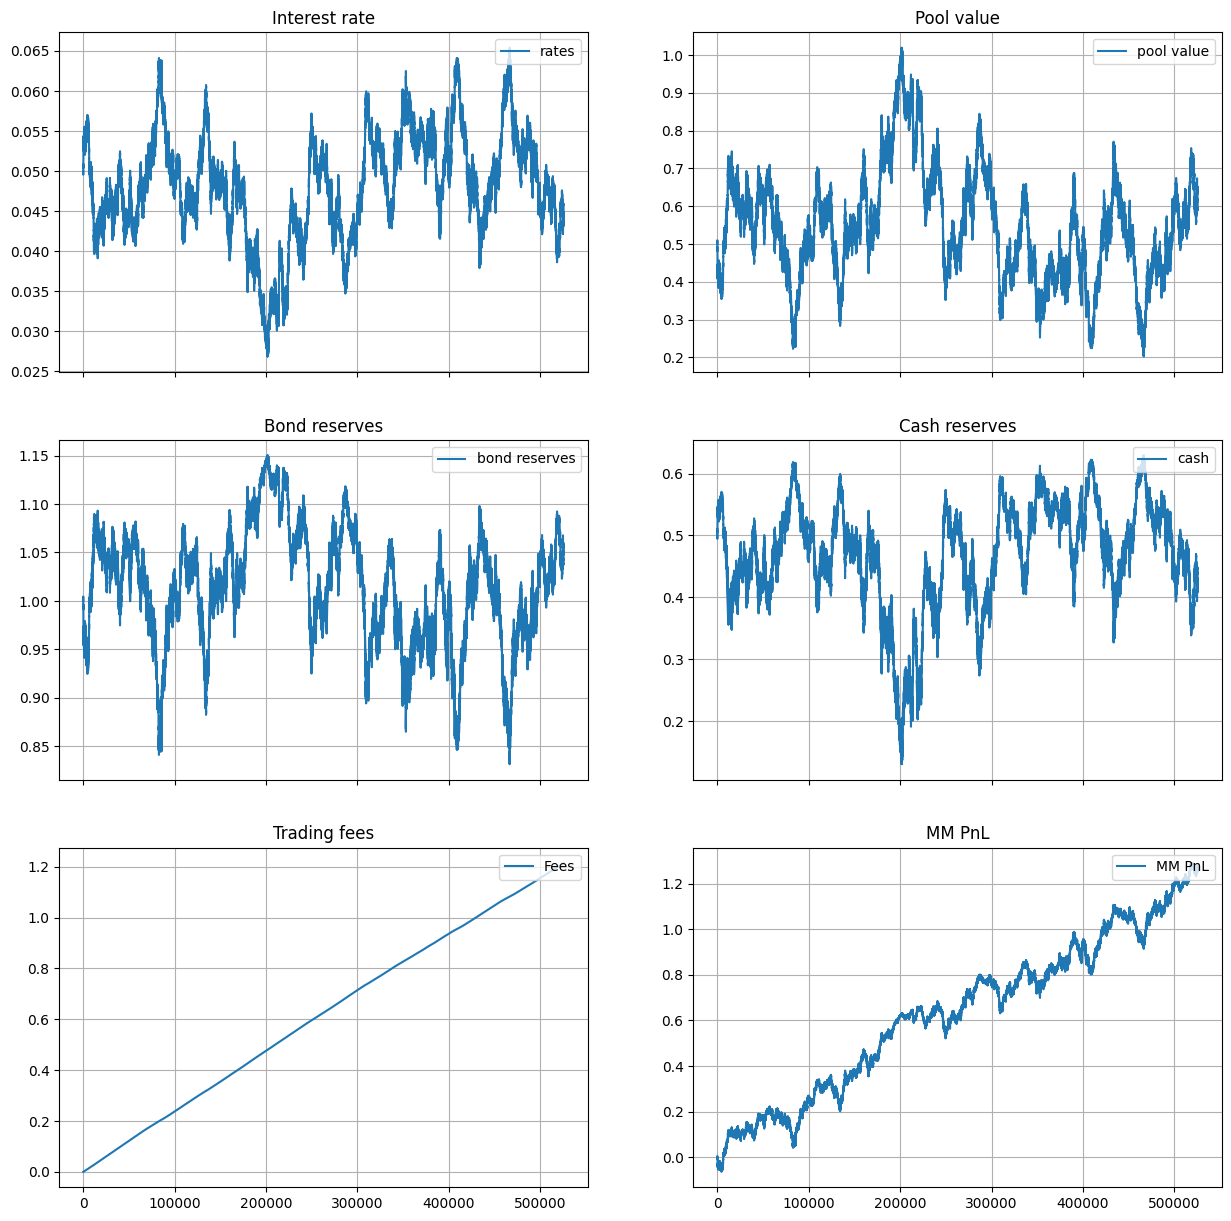

In [61]:
plot_charts(R,V,z,y,fees, MM_PnL)